In [74]:
import random as rnd
from typing import Union
import pandas as pd
import numpy as np
from tabulate import tabulate

from typing import List
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 

In [75]:
input_file  = "data/Ratings Fall 2022.10UG.csv"
output_file = "data/Ratings Fall 2022.10UG.solution.csv"

data_pd = pd.read_csv(input_file,index_col=0, dtype={"player_number":np.intp})
data_pd["slot"] = None


In [76]:
def top_slice(roster: pd.DataFrame, teams:int, players:int) -> pd.DataFrame:
    roster_mean = roster["player_score"].mean()
    
    filter = roster["player_score"] >= roster_mean
    
    selection = data_pd.sort_values("player_score", axis=0, ascending=False)[filter]
        
    selection = selection.head(teams)
    
    selection["slot"] = [z for z in range(0, teams)]
          
    return selection

In [77]:
def bottom_slice(roster: pd.DataFrame, teams:int, players:int) -> pd.DataFrame:
    roster_mean = roster["player_score"].mean()
    
    filter = roster["player_score"] <= roster_mean
    
    selection = data_pd.sort_values("player_score", axis=0, ascending=False)[filter]
    
    selection = selection.tail(teams).iloc[::-1]
    
    selection["slot"] = [z for z in range(0, teams)]
    
    return selection

In [78]:
def top_bottom(roster: pd.DataFrame, slices:int, size:int):
    top    = top_slice(roster, slices, size)
    
    bottom = bottom_slice(roster, slices, size)
    
    selector = pd.concat( [top, bottom] ) 
    
    selector.set_index("player_number")
    
    return selector

In [79]:
def shuffle(roster: pd.DataFrame, teams:int, players:int) -> pd.DataFrame:
    
    top_and_bottom_players = top_bottom(roster,teams, players)
        
    rest_of_players = roster[~roster["player_number"].isin(top_and_bottom_players["player_number"].values)]
         
    shuffle = rest_of_players.sample(frac=1, axis=0)   #90 records top and bottom 20
    
    list_df = np.array_split(shuffle, teams)
    
    slot = 0
    
    for z in list_df:
         z["slot"] = slot
         slot = slot + 1

    sloted = pd.concat(list_df)

    return pd.concat([sloted,top_and_bottom_players])

In [80]:
def solver(teams: int, players: int):
    roster = shuffle(data_pd, teams, players)
    means =[]
    
    teams = roster.groupby("slot")
    
    for team, players in teams:
        t_mean = players["player_score"].mean()
        means.append( { "team": team, "mean": t_mean} )

    means_pd = pd.DataFrame(means)
    stdev = means_pd["mean"].std() # <-- minimize this
    return (stdev, roster)

In [81]:
from math import ceil

def main(itterations: int):
    
    players_per_team = 10
    roster_mean = data_pd["player_score"].mean()
    
    league_teams = int(ceil( len(data_pd) / players_per_team ))
    
    print(f"league_teams: {league_teams}")

    min_min = itterations
    
    selection: List[pd.DataFrame] = None

    for i in range(0, min_min):
        std, solv_teams = solver(league_teams, players_per_team)
         
        selection = solv_teams
        
        if std < min_min:
            
            print(f"itteration: {i} min: {min_min}")
            
            min_min = std
            
            solv_teams.sort_values(by="slot").to_csv(output_file)
            
            slots = solv_teams[["slot", "player_score"]].groupby(["slot"]).mean(["player_score"])
            
            slots.plot.bar(rot=0)
            plt.show()
        
        
    print("roster_mean", roster_mean)
    print("min_min", min_min)

    solution = pd.concat(selection).sort_values(by="slot")
    
    solution.to_csv(output_file)

    slots = solution[["slot", "player_score"]].groupby(["slot"]).mean(["player_score"])
    
    ax = slots.plot(kind="bar",  rot=0, animated=True,fill=False)
    ax.set_title("Solution")
    plt.show()
    
    

league_teams: 7
itteration: 0 min: 1000000


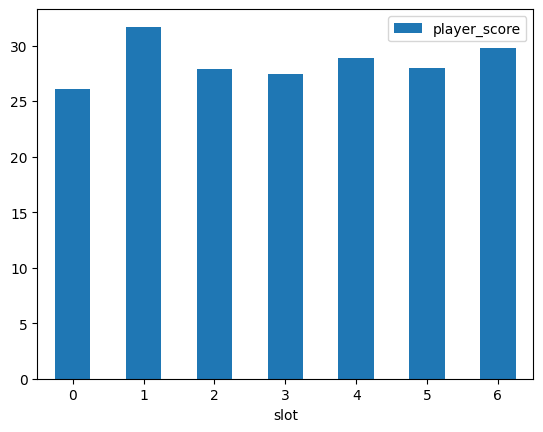

itteration: 1 min: 1.8100249932502246


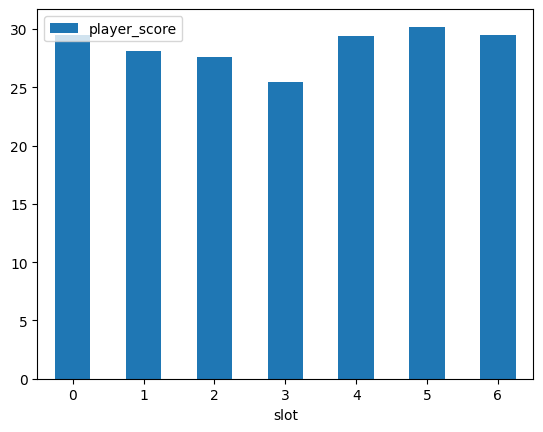

itteration: 4 min: 1.615402058165028


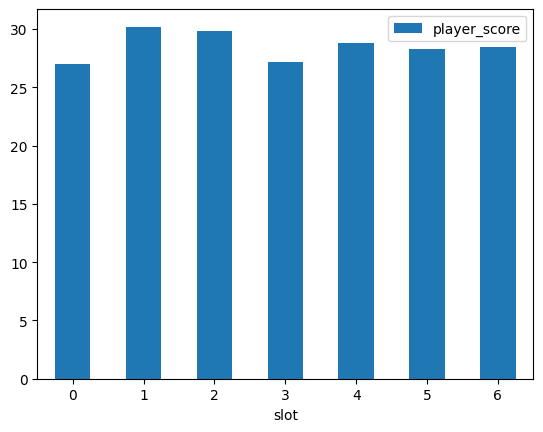

itteration: 11 min: 1.1998015708957086


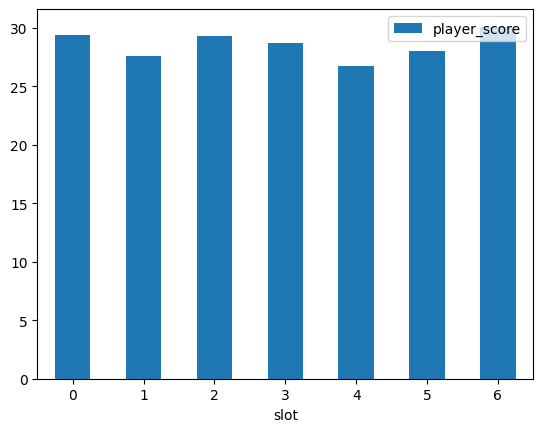

itteration: 16 min: 1.1787806452108933


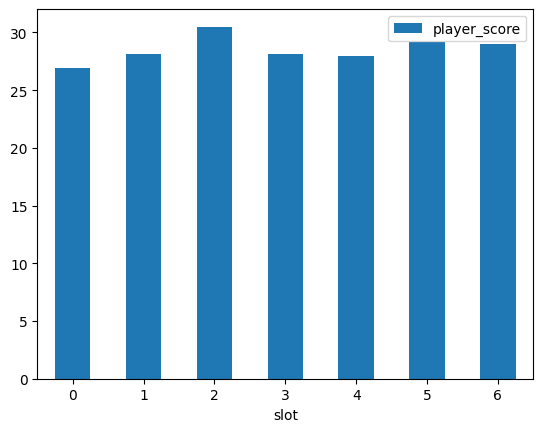

itteration: 19 min: 1.1443442705426587


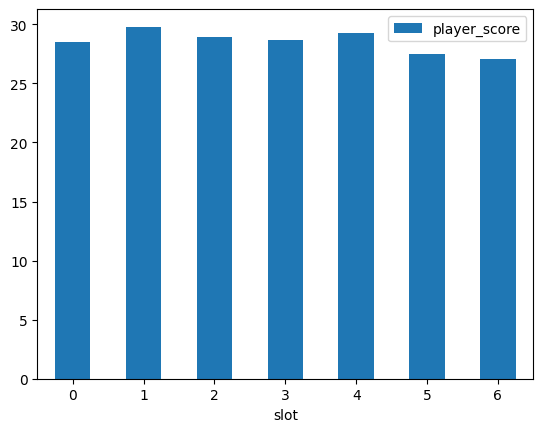

itteration: 129 min: 0.9554355775546264


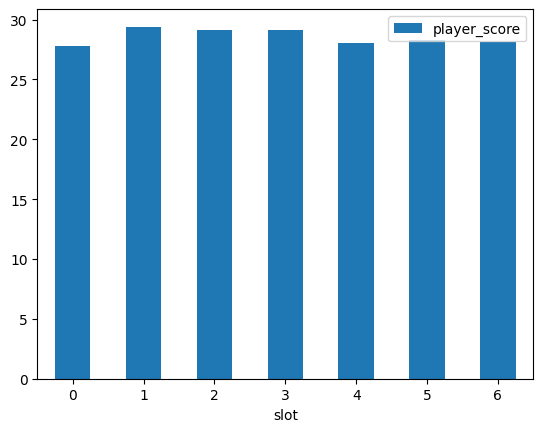

itteration: 259 min: 0.6399404734221842


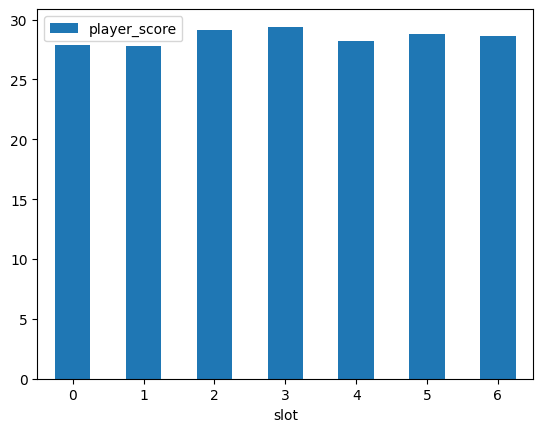

itteration: 440 min: 0.605136741729071


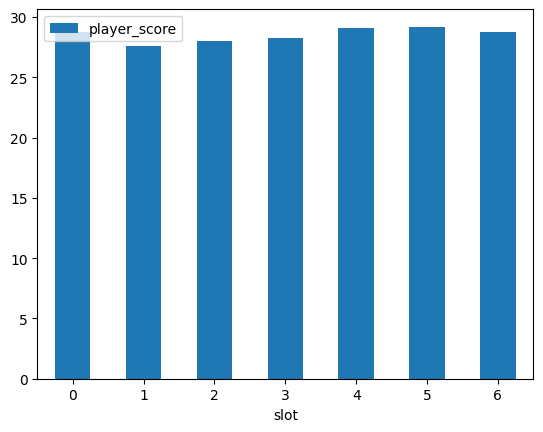

itteration: 537 min: 0.5940177967511937


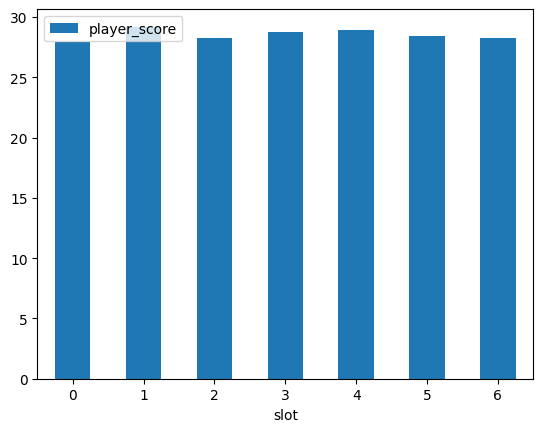

itteration: 2031 min: 0.4429339411136565


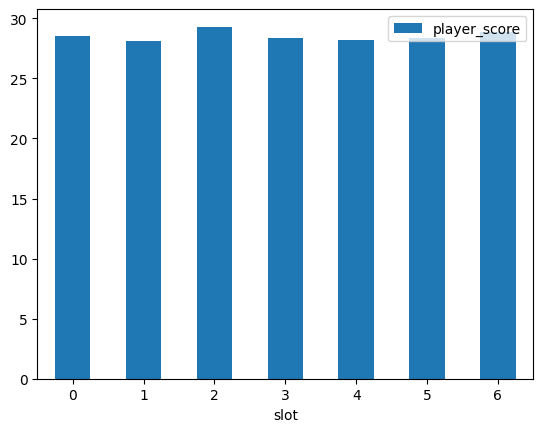

itteration: 3315 min: 0.4197504927816955


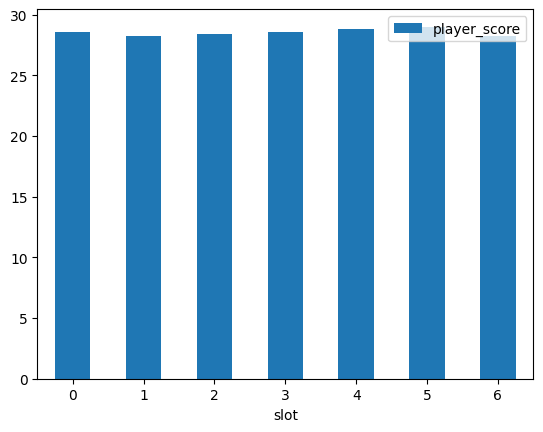

In [82]:
 
# if __name__ == "__main__":
main(1000000)

